### This experiment aims at finding foreground mask from NDVI image

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from itertools import product
from PIL import Image
from Image_Segmentation import *
from plantcv import plantcv as pcv
import plantcv
import pandas as pd
from sklearn.decomposition import PCA
from skimage.filters import threshold_li
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
pcv.params.debug = None

In [ ]:
segmentation_model_weights_path = 'yolo_segmentation_model.pt'
segmentation_model = load_yolo_model(segmentation_model_weights_path)
device = 'cpu'

In [ ]:
def tile(image, d=2):

  w, h = image.size
  grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
  boxes = []

  for i, j in grid:
      box = (j, i, j+d, i+d)
      boxes.append(box)

  return boxes

#### Load Raw Image

In [ ]:
image_path = '../../../new data/Corn/2023-12-20_CornRow2_1/Image_000004.tif'
raw_image = Image.open(image_path)

#### Get individual channels and color image

In [ ]:
def get_ndvi_mask_from_raw_image(raw_image, thresh):

    size = raw_image.size[0] // 2
    slices = tile(image = raw_image, d = size)
    index = 0
    image_stack = np.zeros((size, size, len(slices)))

    for box in slices:

        image_stack[:, :, index] = np.array(raw_image.crop(box))
        index += 1

    red = np.expand_dims(image_stack[:, :, 1], axis=-1)
    green = np.expand_dims(image_stack[:, :, 0], axis=-1)
    red_edge = np.expand_dims(image_stack[:, :, 2], axis=-1)
    NIR = np.expand_dims(image_stack[:, :, -1], axis=-1)

    composite_image = np.concatenate((green, red_edge, red), axis=-1) * 255
    color_image = ((composite_image - composite_image.min())*255 / (composite_image.max() - composite_image.min())).astype(np.uint8)
    results = segmentation_model.predict(color_image, conf = 0.128, device = device)
    result = results[0]
    mask = preprocess_mask(result.masks.data)
    binary_mask_np = generate_binary_mask(mask)
    segmented_color_image = overlay_mask_on_image(binary_mask_np, color_image)
    original_image = segmented_color_image
    image = segmented_color_image
    gray_image = pcv.rgb2gray(rgb_img = image)
    binary_threshold = threshold_li(gray_image)
    binary_image = gray_image > binary_threshold
    binary_image = binary_image.astype(int)

    filled_binary_image = pcv.fill(bin_img = binary_image, size = 10)

    object_contours, object_hierarchies = pcv.find_objects(img = np.uint8(original_image), mask = filled_binary_image)
    rectangle_roi_contour, rectangle_roi_hierarchy= pcv.roi.rectangle(img = original_image, x = 95, y = 5, h = 500, w = 350)
    roi_object_contours, roi_object_hierarchies, roi_mask, roi_object_areas = pcv.roi_objects(img = original_image,
                                                                   roi_contour = rectangle_roi_contour,
                                                                   roi_hierarchy = rectangle_roi_hierarchy,
                                                                   object_contour = object_contours,
                                                                   obj_hierarchy = object_hierarchies,
                                                                   roi_type = 'partial')

    composed_object, composed_mask = pcv.object_composition(img = original_image,
                                                            contours = roi_object_contours,
                                                            hierarchy = roi_object_hierarchies)

    masked_color_image = pcv.apply_mask(img = original_image, mask = composed_mask, mask_color = 'black')
    masked_red_image = pcv.apply_mask(img = red, mask = composed_mask, mask_color = 'black')
    masked_NIR_image = pcv.apply_mask(img = NIR, mask = composed_mask, mask_color = 'black')
    epsilon = 1e-10
    ndvi_image_original = (NIR-red)/(NIR+red+epsilon)
    ndvi_mask_original = ndvi_image_original >= thresh
    red = masked_red_image
    NIR = masked_NIR_image
    ndvi_image = (NIR-red)/(NIR+red+epsilon)
    ndvi_min = -1.0
    ndvi_max = 1.0
    ndvi_mask = ndvi_image >= thresh

    return ndvi_image_original, ndvi_mask_original, ndvi_image, ndvi_mask, color_image

In [ ]:
def plot_ndvi_image(ndvi_image):

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(ndvi_image, vmin = -1, vmax = 1, cmap = mpl.colormaps['RdYlGn'])
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.suptitle('NDVI')

    #Image from plot
    ax.axis('off')
    fig.tight_layout(pad=0)

    # To remove the huge white borders
    ax.margins(0)
    plt.show()

    # fig.canvas.draw()
    # image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    # image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
ndvi_image_original, ndvi_mask_original, ndvi_image, ndvi_mask, color_image = get_ndvi_mask_from_raw_image(raw_image, 0.15)


0: 640x640 1 Plant, 907.9ms
Speed: 17.5ms preprocess, 907.9ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)
(512, 512)


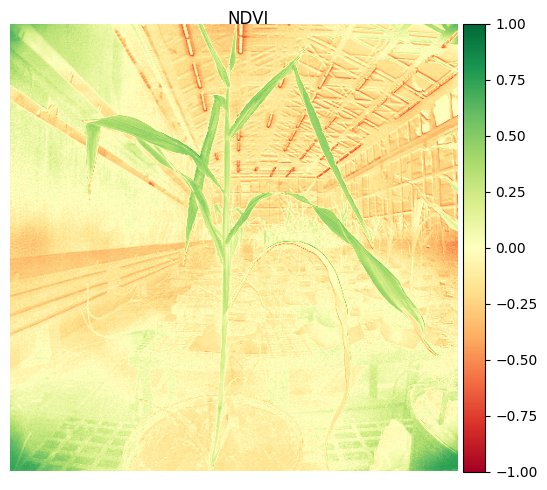

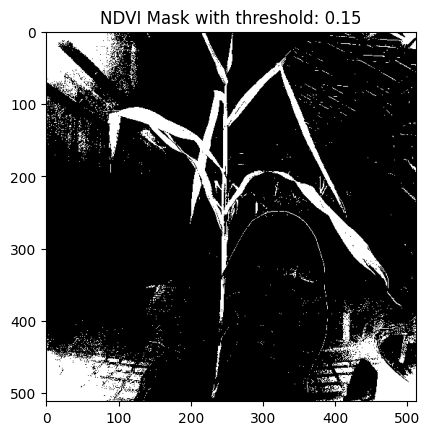

In [ ]:
plot_ndvi_image(ndvi_image_original)
thresh = 0.15
plt.imshow(ndvi_mask_original, cmap = 'gray')
plt.title('NDVI Mask with threshold: '+str(thresh))
plt.show()

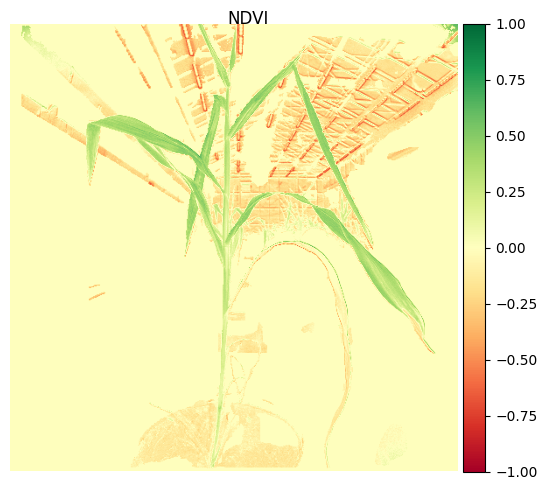

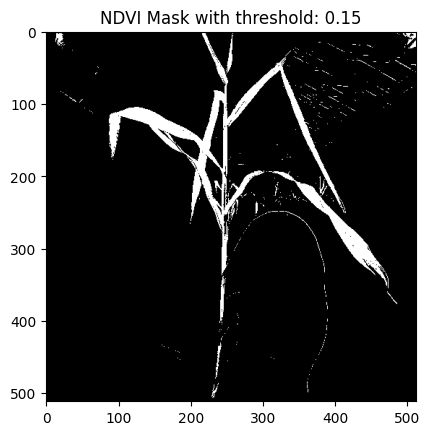

In [ ]:
plot_ndvi_image(ndvi_image)
thresh = 0.15
plt.imshow(ndvi_mask, cmap = 'gray')
plt.title('NDVI Mask with threshold: '+str(thresh))
plt.show()

In [ ]:
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
ndvi_mask_int = ndvi_mask*255
ndvi_mask_int = ndvi_mask_int.reshape(ndvi_mask_int.shape[0], ndvi_mask_int.shape[1])
ndvi_mask_rgb = np.stack((ndvi_mask_int,ndvi_mask_int,ndvi_mask_int), axis = -1)
result_image = np.concatenate((color_image, ndvi_mask_rgb), axis=1)
cv2.imwrite('result_image.png',result_image)

True

In [ ]:
skeleton = pcv.morphology.skeletonize(mask=ndvi_mask)

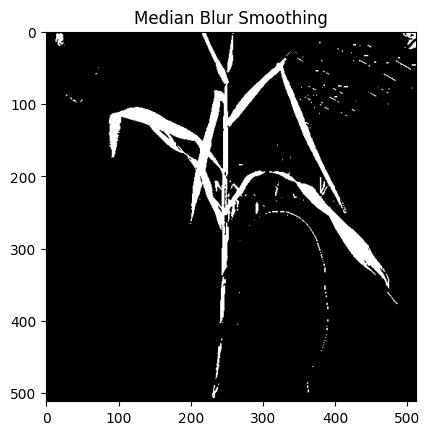

In [ ]:
smoothed_mask = pcv.median_blur(ndvi_mask, 2)
plt.imshow(smoothed_mask, cmap = 'gray')
plt.title('Median Blur Smoothing')
plt.show()

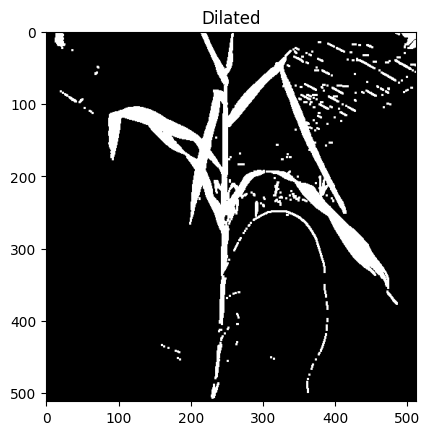

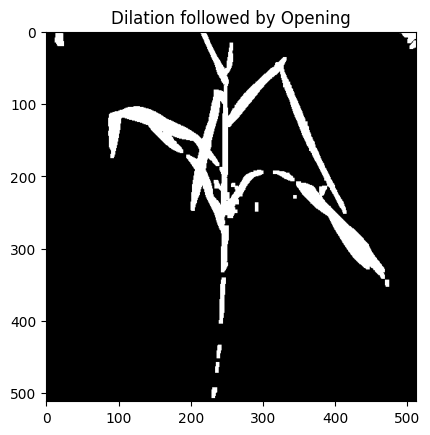

In [ ]:
#dilate and open
kernel_3 = np.ones((3, 3), np.uint8)
kernel_5 = np.ones((5, 5), np.uint8)
dilated = cv2.dilate((ndvi_mask*1).astype(np.uint8), kernel_3, iterations = 1)
dilated_opened = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel_3, iterations=2)
plt.imshow(dilated, cmap = 'gray')
plt.title('Dilated')
plt.show()
plt.imshow(dilated_opened, cmap = 'gray')
plt.title('Dilation followed by Opening')
plt.show()

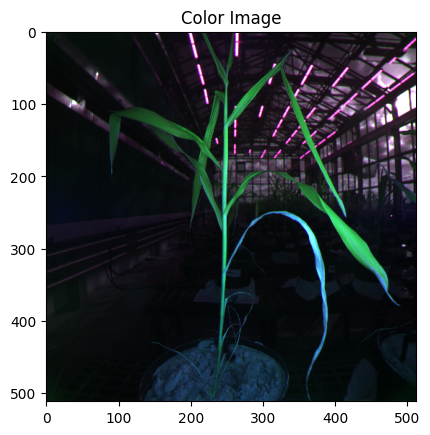

In [ ]:
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Color Image')
plt.show()